In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os                                

from numba import njit
from scipy.optimize import curve_fit
from organism import *
from support import *

%matplotlib inline

/home/edi/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## CSV generator
The following function makes a "csv" file containig information of a converged game with a specific size 

In [4]:
def generate_data(Runs, Dim, periodic=True):                                                                                     # It takes the number of the times we want to play the game (Runs) , The size of the world (Cells in a row/column) and the border condition
    headers = ['Convergence Time', 'Periodic'] + list(Organisms.keys())                                                          # Headers of the Dataframes we want to make
    with open(f"{str(Runs)}_{str(Dim)}x{str(Dim)}{'_Periodic'*periodic}.csv", "w") as f:                                         # Stating to write the headers into the "csv" file
        f.write(",".join(headers)+"\n")
    
    for i in range(Runs):                                                                    
        world = np.random.randint(0, 2, (Dim, Dim), np.int8)                                                                     # Building the world randomly (alive and dead cells)
        itt = 0                                                                                                                  # Number of iterations
        Density = [world.sum() / Dim**2]                                                                                         # Density (cells alive over the world's surface)
        while not(itt > 90 and (all(c==Density[-1] for c in Density[-10:]) or all(c==Density[-30] for c in Density[-90::30]))):  # Convergence Condition
            itt += 1                                                                                                             # Count iteration
            world = next_gen(world, periodic)                                                                                    # Use "next_gen" func. 
            Density.append(world.sum() / world.size)                                                                             # Add the next generation density
        
        line = [str(itt), str(periodic)] + [str(sum([search(world, org, True) for org in Organisms[k]])) for k in Organisms]     # The Information about each converged game (Convergence Time , Periodic condition and Number of each Organism)
        
        with open(f"{str(Runs)}_{str(Dim)}x{str(Dim)}{'_Periodic'*periodic}.csv", "a") as f:                                     # Write/append the infor mation to our "csv" file 
            f.write(",".join(line)+"\n")

## Convergence time vs world size

Now we extract the previously recorded information to plot a graph that show the relation

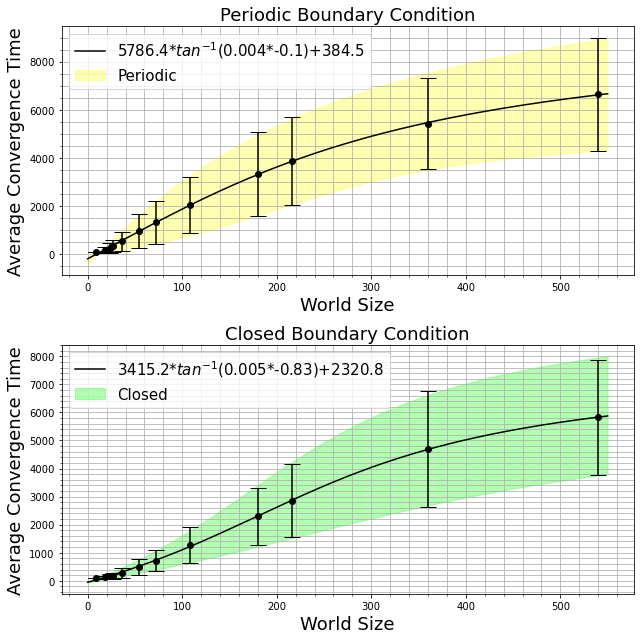

In [5]:
files = os.listdir("Data")               # print the list of files present in the current working directory

## Open Border Files
periodics_files = np.array([file for file in files if "Periodic" in file])                                                 # Get periodic files - using the file name
periodic_convergence = np.array([pd.read_csv("Data/"+file).mean()['Convergence Time'] for file in periodics_files])  # Get mean periodic convergence time in first 500 iterations
periodic_error = np.array([(pd.read_csv("Data/"+file).std()['Convergence Time']) for file in periodics_files])       # Get std deviation of periodic convergence time in first 500 iterations
periodic_N = np.array([int(periodics_file.split('x')[0].split('_')[1]) for periodics_file in periodics_files])             # Get the size of each world with open border

## Closed Border Files (same as above)
non_p_files = np.array([file for file in files if "Periodic" not in file])
non_p_convergence = np.array([pd.read_csv("Data/"+file).mean()['Convergence Time'] for file in non_p_files])
non_p_errors = np.array([(pd.read_csv("Data/"+file).std()['Convergence Time']) for file in non_p_files])
non_p_N = np.array([int(non_p_file.split('x')[0].split('_')[1]) for non_p_file in non_p_files]) 


## Fitting Curve Function 
def f(x, a, b ,c, d):
    return a*np.arctan(b*x+c) + d                #General Arctangent Function 

fig, ax = plt.subplots(2, 1, figsize=(9, 9))    # Add Subplots
x = np.linspace(0, 550 , 1000)                   # X axis for plot the fitted lines


## Open Border Plotting the time of convergence per world size
params, covariance = curve_fit(f ,periodic_N, periodic_convergence)                                 # Fit the curve on cell sizes and mean convergence time for each world and get the parameters
params_high, covar_2 = curve_fit(f, periodic_N, periodic_convergence + periodic_error)              # Fit for the higher band of errors(std) 
params_low, covar_2 = curve_fit(f, periodic_N, periodic_convergence - periodic_error)               # Fit for the lower band of the errors(std) 

## Plot the error bars
ax[0].errorbar(periodic_N, periodic_convergence, yerr=periodic_error, fmt='o', color='k', capsize=8)

## Plot the Fitted line for mean convergence time
ax[0].plot(x, f(x, params[0], params[1], params[2], params[3]), color='k' , label= f'{params[0].round(1)}' + "$*$" + "$tan^{-1}$" + "(" + f'{params[1].round(3)}' + "*" + f'{params[2].round(2)}' + ')' + '+' + f'{params[3].round(1)}' )

## Fill between the lower and upper band fitted curves with a color 
ax[0].fill_between(x, f(x, params_high[0], params_high[1], params_high[2], params_high[3]),
                   f(x, params_low[0], params_low[1], params_low[2], params_low[3]),
                   alpha=0.3, color='yellow', label="Periodic" )

## Set everythibng else needed for the plots
ax[0].set_xlabel('World Size', fontsize=18)
ax[0].set_ylabel('Average Convergence Time', fontsize=18)
ax[0].grid(which='both')
ax[0].minorticks_on()
ax[0].set_title('Periodic Boundary Condition', fontsize=18)
ax[0].legend(fontsize=15)


## Doing the same for Closed Border Worlds
params, covariance = curve_fit(f ,non_p_N, non_p_convergence)
params_high, covar_2 = curve_fit(f, non_p_N,non_p_convergence + non_p_errors)
params_low, covar_2 = curve_fit(f, non_p_N, non_p_convergence - non_p_errors, maxfev=10000)

ax[1].errorbar(non_p_N, non_p_convergence, yerr=non_p_errors, fmt='o', color='k', capsize=8)
ax[1].plot(x, f(x, params[0], params[1], params[2], params[3]), color='k' , label= f'{params[0].round(1)}' + "$*$" + "$tan^{-1}$" + "(" + f'{params[1].round(3)}' + "*" + f'{params[2].round(2)}' + ')' + '+' + f'{params[3].round(1)}' )
ax[1].fill_between(x, f(x, params_high[0], params_high[1], params_high[2], params_high[3]), f(x, params_low[0], params_low[1], params_low[2], params_low[3]), alpha=0.3, color='lime',  label="Closed")
ax[1].set_xlabel('World Size', fontsize=18)
ax[1].set_ylabel('Average Convergence Time', fontsize=18)
ax[1].grid(which='both')
ax[1].minorticks_on()
ax[1].set_title('Closed Boundary Condition', fontsize=18)
ax[1].legend(loc='upper left', fontsize=15)
plt.tight_layout()

Now we create a Pandas dataset for our organisms and we show how the population composition varies in different world 

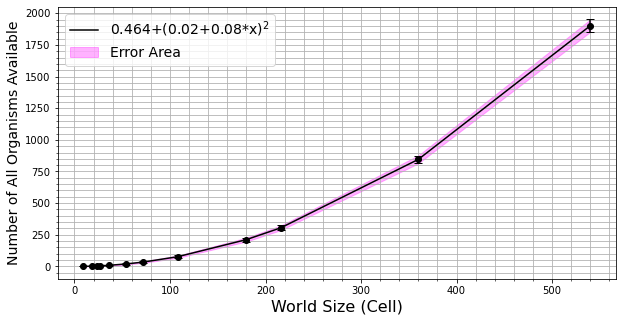

In [6]:
## Making a Huge dataset of our "CSV" files
FINAL_DF = pd.read_csv("Data/"+periodics_files[0])             # Making the first Data Frame with one of the periodic "csv" files (initial dataframe)
FINAL_DF["Cell Size"] = periodic_N[0]

for i in range(1,len(periodics_files)):                        # Add all other periodic files to it
    df_temp = pd.read_csv("Data/" + periodics_files[i])
    df_temp["Cell Size"] = periodic_N[i]
    FINAL_DF = pd.concat( [FINAL_DF , df_temp] , ignore_index=True)

for i in range(0,len(non_p_files)):                            # Add all other non_periodic files to it
    df_temp = pd.read_csv("Data/" + non_p_files[i])
    df_temp["Cell Size"] = non_p_N[i]
    FINAL_DF = pd.concat( [FINAL_DF , df_temp] , ignore_index=True)

    
FINAL_DF.to_csv('FINAL_DATASET.csv')                           # Save the final Dataset


## Making a column of the total number of most found stable organisms and call it "Important Still Shapes"
FINAL_DF["Important Still Shapes"] = FINAL_DF['Block'] + FINAL_DF['Bee Hive'] + FINAL_DF['Loaf'] + FINAL_DF['Boat'] + FINAL_DF['Ship'] + FINAL_DF['Tub'] + FINAL_DF['Ship']

## Making a column of the total number of all organisms and name it "All Shapes"
FINAL_DF["All Shapes"] = FINAL_DF.iloc[:, 2:20].sum(axis=1)

## Making a column of all other kind of organism like oscillators and scarce/rare organism  and name it "Other Shapes"
FINAL_DF["Other Shapes"] = FINAL_DF["All Shapes"] - FINAL_DF["Important Still Shapes"] 

## Finding the average numbr of organisms we found for different sizes of the world with of course their error
All_mean = FINAL_DF.groupby(['Cell Size'])['All Shapes'].mean()
All_std = FINAL_DF.groupby(['Cell Size'])['All Shapes'].std()


## Creating variables for plotting the results
x_mean = All_mean.index.to_numpy()
y_mean = All_mean.to_numpy()
x_upper = All_std.index.to_numpy()
y_upper = All_std.to_numpy() + y_mean
x_lower = All_std.index.to_numpy()
y_lower = -All_std.to_numpy() + y_mean


## Using the polinamial function for fitting lines corresponding to our periviouse observations and the dataset 
def fit_shape(x , a , b , c):
    return (a+b*x)**2+c

3# Finding the fitted cures for the main data and its errors
param_upper  , covar_upper = curve_fit(fit_shape , x_upper  , y_upper)
param_lower  , covar_lower = curve_fit(fit_shape , x_lower  , y_lower)
param  , covar = curve_fit(fit_shape , x_mean  , y_mean)

## Plot the Results
plt.figure(figsize=(10,5))
plt.plot(x_mean, fit_shape(x_mean, param[0], param[1], param[2]), color='k' , label=(f"{param[2].round(3)}"+"+"+"("+f"{param[0].round(2)}"+"+"+f"{param[1].round(2)}*x"+"$)^{2}$") )
plt.errorbar(x_mean , y_mean , yerr= y_upper-y_mean, fmt='o', color='k', capsize=4 )
plt.fill_between( x_mean ,fit_shape(x_upper , param_upper[0], param_upper[1], param_upper[2]) ,
                 fit_shape(x_lower, param_lower[0], param_lower[1], param_lower[2]),
                 alpha=0.3, color='Magenta' , label = ("Error Area"))
plt.ylabel("Number of All Organisms Available" , fontsize=14)
plt.xlabel("World Size (Cell)" , fontsize=16)
plt.grid(which='both')
plt.minorticks_on()
plt.legend( loc = 'upper left' , fontsize=14)
plt.show()

/tmp/ipykernel_52791/4102207324.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shape_df.loc[:,"Other Shapes"] =  shape_df.loc[:,"Other Shapes"].sub(shape_df.loc[:,"Blinker"])                         # Just to remove "Blinkers" from "Other Shapes" since now we need them separated
/tmp/ipykernel_52791/4102207324.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shape_df.iloc[:,2:6] = shape_df.iloc[:,2:6].div(shape_df["All Shapes"], axis=0)*100                                     # Normalize and report 

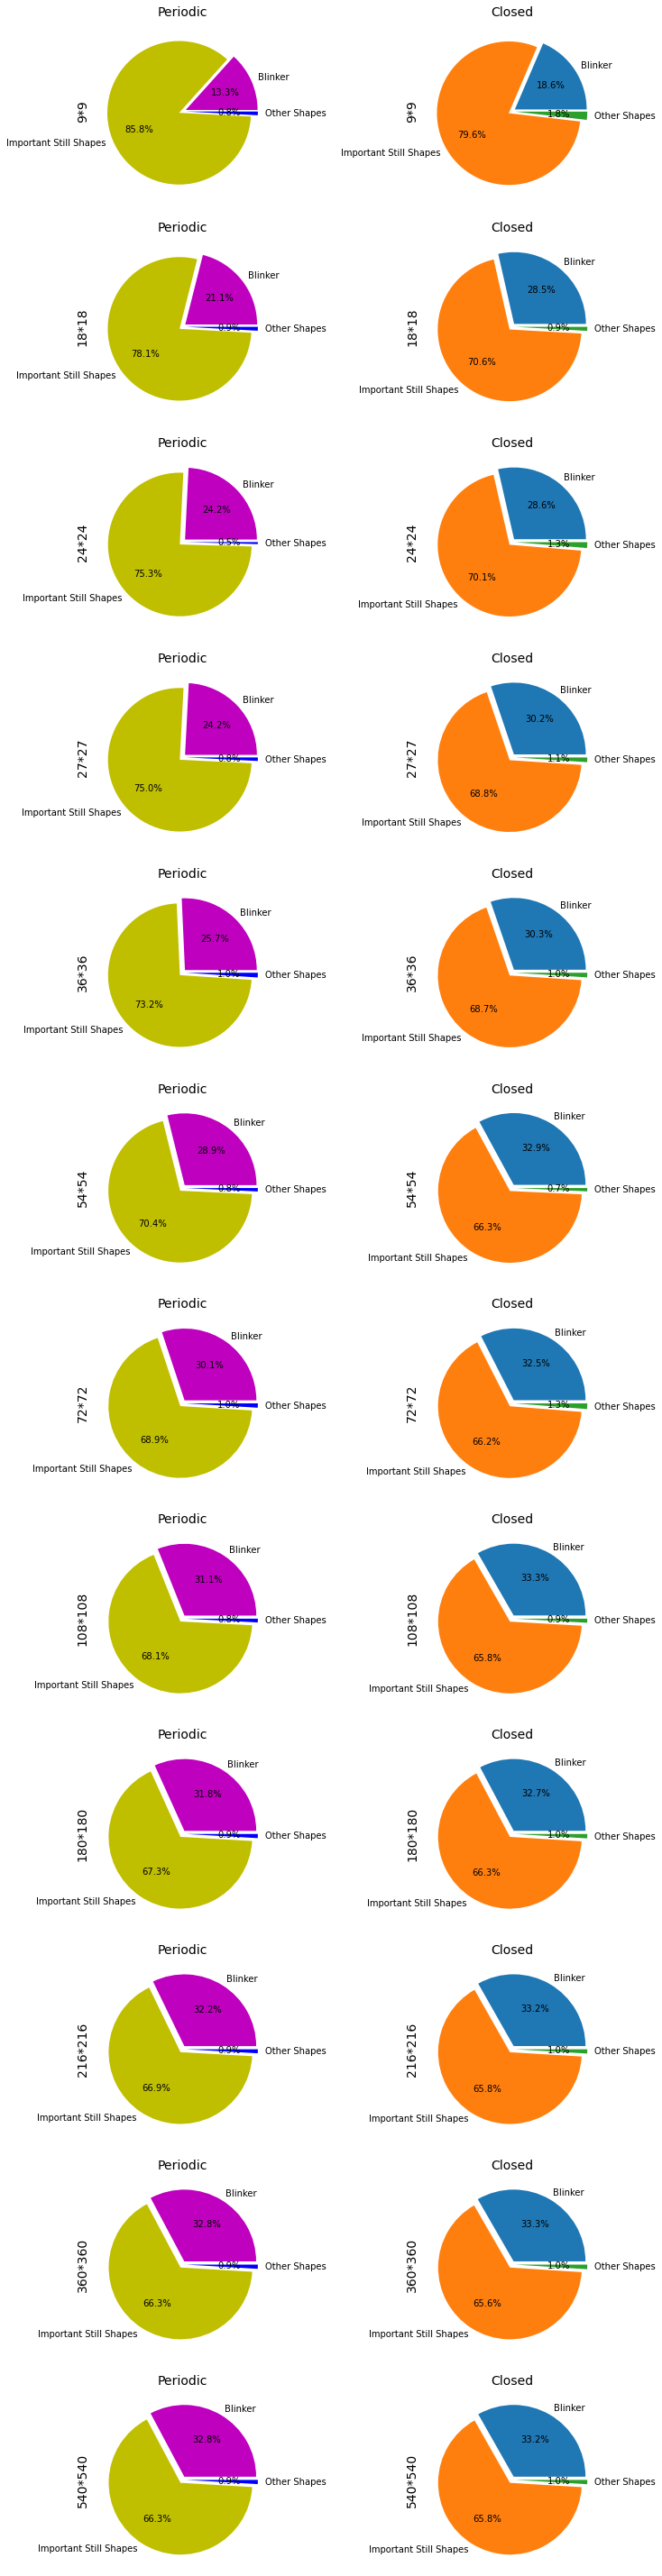

In [7]:
## Creat an special sub_dataframe to have various pie charts to demonstrate later. It contains number of Still organisms, blinkers(most found oscillating organism) and all the other organisms 
shape_df = FINAL_DF[["Periodic" , "Cell Size" , "Blinker" , "Important Still Shapes" , "Other Shapes" , "All Shapes"]] 
shape_df.loc[:,"Other Shapes"] =  shape_df.loc[:,"Other Shapes"].sub(shape_df.loc[:,"Blinker"])                         # Just to remove "Blinkers" from "Other Shapes" since now we need them separated 
shape_df.iloc[:,2:6] = shape_df.iloc[:,2:6].div(shape_df["All Shapes"], axis=0)*100                                     # Normalize and report in percentage
shape_df_g = shape_df.groupby(["Periodic" , "Cell Size"]).mean()                                                        # Get the mean value for each kind of shape for our pie plots

## Make the Pie array just for making the pie charts easier to plot
pie = shape_df_g.iloc[:,0:3].to_numpy()                                 # Getting the shapes
pie_p = pie[0:12,:]                                                     # For open border
pie_non_p = pie[12:,:]                                                  # For closed border
Labels = ["Blinker" , "Important Still Shapes" , "Other Shapes"]        # labels of pie chart
Exploid = [0.05,0.05 ,0.05]                                             # argument for pie charts 
colors = ["m","y" ,"b"]                                                 # colors

## Plotting the charts
fig , Ax = plt.subplots(12,2 , figsize = (12,52))

## For open border
for i in range(12):
    ax = Ax[i,0]
    ax.pie(pie_p[i,:], explode = Exploid  , labels = Labels, colors = colors  , autopct='%1.1f%%')
    ax.set(adjustable='box', aspect='equal')
    ax.set_ylabel(f"{list(shape_df_g.index.to_numpy()[i])[1]}"+"*"+f"{list(shape_df_g.index.to_numpy()[i])[1]}" , fontsize=14)
    ax.set_title("Periodic" , fontsize=14)

## For closed border 
for i in range(12):
    ax = Ax[i,1]
    ax.pie(pie_non_p[i,:], explode = Exploid , labels = Labels  , autopct='%1.1f%%' )
    ax.set(adjustable='box', aspect='equal')
    ax.set_ylabel(f"{list(shape_df_g.index.to_numpy()[i])[1]}"+"*"+f"{list(shape_df_g.index.to_numpy()[i])[1]}" , fontsize=14 )
    ax.set_title("Closed" , fontsize=14)
plt.show()